In [ ]:
import numpy as np 
from sklearn.metrics import classification_report, roc_curve
import plotly.plotly as py
import plotly.tools as tls
import matplotlib.pyplot as plt
import os
import math
from string import punctuation
import re
import sys
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
import zipfile
import progressbar
from sklearn.feature_extraction.text import CountVectorizer
from google.colab import files
import pickle
from keras.models import load_model, model_from_json
import random


ImportError: ignored

In [ ]:
#englishWords = set()
#with open('words_alpha.txt', 'r') as handle:
#    lines = handle.readlines()
#    for line in lines:
#      word = line.strip()
#      englishWords.add(word)

In [ ]:
with open('contractions.pickle', 'wb') as handle:
    pickle.dump(contractions, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('wordConv.pickle', 'wb') as handle:
    pickle.dump(wordConvDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#ignoredW = set()
#wordConvDict["woz"] = "was"
#print(len(englishWords))
#for key in contractions.keys():
#  print(key,":",contractions[key])

370099


In [ ]:
print(len(wordConvDict.keys()))
print(len(contractions.keys()))


512
191


In [ ]:



def BuildModel(modelW):
  print("Restoring model structure")
  json_file = open("model.json", 'r')
  temp_model_json = json_file.read()
  json_file.close()
  temp_model = tf.keras.models.model_from_json(temp_model_json)
  
  if modelW==1:
    print("Restoring model weights")
    temp_model.load_weights("model.h5")
  
  print("Compiling Model")
  temp_model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return temp_model


def vectorizeData(shuffle,x_temp,y_temp):
  
  if shuffle==1:
    print("Zipping x and y together for shuffling")
    shuffleTemp = list(zip(x_temp, y_temp))

    print("Shuffling Sets")
    random.shuffle(shuffleTemp)

    print("Un-Zipping Sets")
    x_temp, y_temp = zip(*shuffleTemp)
  
  print("Restoring Vectorizer From vectorize.pickle")
  with open('vectorize.pickle', 'rb') as handle:
    vec_dict = pickle.load(handle)
  vectorizer = CountVectorizer(vocabulary=vec_dict)
  
  print("Transforming Data")
  x_temp = vectorizer.transform(x_temp)
  
  print("Categorizing Labels")
  y_train_ad = list()
  for i in range(0,len(y_temp)):
    if y_temp[i] == 0:
      y_train_ad.append(0)
    else:
      y_train_ad.append(1)
   
  y_temp = to_categorical(y_train_ad)
  return x_temp,y_temp
  
def saveTxt(filename,x_in,y_in):
  print("Saving Processed Data...")
  fd = open(filename,"w")
  for i in range(0,len(y_in)):
    tempStr = str(y_in[i]) + "\"" + x_in[i] +"\n"
    fd.write(tempStr)
  fd.close()
  print("...All Processed Data Saved to File:",filename)

def loadTxt(filename=None):
  if filename is None:
    print("Select .csv File to Read and Process:")
    upload = files.upload()
    filename = list(upload.keys())[0]
    
  print("Loading Pre-Processed Data...")
  sys.stdout.flush()

  y_temp = list()
  x_temp = list()

  fd = open(filename,"r")

  lines = fd.readlines()
  prog = 0
  bar = progressbar.ProgressBar(maxval=len(lines), \
    widgets=[progressbar.Percentage(), ' ', progressbar.Bar('=', '[', ']'), ' ', progressbar.SimpleProgress()])
  bar.start()

  for line in lines:
    wList = line.split("\"")
    y_temp.append(int(wList[0]))
    x_temp.append(wList[-1].strip())
    prog+=1
    bar.update(prog)
  
  fd.close()
  bar.finish()
  print("...All Training Data Loaded\n")
  return x_temp, y_temp


def procCSV(filename=None):
  
#  with open('contractions.pickle', 'rb') as handle:
#    contractions = pickle.load(handle)
    
#  with open('wordConv.pickle', 'rb') as handle:
#    wordConvDict = pickle.load(handle)
  
#  newPunc = punctuation.replace("'","")
  if filename is None:
    print("Select .csv File to Read and Process:")
    upload = files.upload()
    filename = list(upload.keys())[0]
    
  print("Reading and Pre-Processing Data...")
  sys.stdout.flush()
  
  x_temp = list()
  y_temp = list()
  fd = open(filename, "r", errors='ignore')
  lines = fd.readlines()
  fd.close()
  
#  weirdW = {}
  
  prog = 0
  bar = progressbar.ProgressBar(maxval=len(lines), \
    widgets=[progressbar.Percentage(), ' ', progressbar.Bar('=', '[', ']'), ' ', progressbar.SimpleProgress()])
  bar.start()
  for line in lines:
    line = line.lower()
    wList = line.split("\"")
    newL = []
    for seg in wList:
      if (len(seg) < 5 and "," in seg) or (len(seg) == 0) or "\n" in seg:
        count = 1
      else:
        newL.append(seg)
    curLab = newL[0].rstrip()
    curTweet = ''
    for elem in newL[5:]:
      tempElem1 = re.sub(r'\.\.+',' ',elem)
      tempElem1 = re.sub(r'(^|\s)@[a-z0-9]*?\s','',tempElem1)
      tempElem1 = re.sub(r'&quot;',' ',tempElem1)
      tempElem = ''.join(c for c in elem if c not in punctuation)
      tempWords = tempElem.split()
      for temp in tempWords:
        rplW = temp
#        if "'" in temp and temp not in contractions.keys():
#          if "n'" in temp[-2:]:
#            rplW.replace("'","g")
#        elif temp in contractions.keys():
#          resultCont = contractions[temp]
#          resultContL = resultCont.split("/")
#          if len(resultContL) > 1:
#            rplW = resultContL[random.randint(0,len(resultContL)-1)]
#          else:
#            rplW = resultContL[0]
#        elif "'ll" in rplW:
#          rplW.replace("'ll"," will")
        curTweet += rplW
        curTweet += ' '
  
    curTweet = curTweet.lower()  
    curTweet = re.sub(r'__[0-9]/[0-9]','',curTweet)
    curTweet = re.sub(r'(^|\s)rt(\s|$)',' retweet ',curTweet)
    curTweet = re.sub(r'[a-z0-9\.]*?@[a-z0-9]*?\.(gov|edu|net|org|com).*?','address',curTweet)
    curTweet = re.sub(r'@',' at ',curTweet)
    curTweet = re.sub(r'[!?]+',' ',curTweet)
    curTweet = re.sub(r'\.\.+',' ',curTweet)
    curTweet = re.sub(r'\$\$+',' money ',curTweet)
    curTweet = re.sub(r'[\'\.:,;-]+\s',' ',curTweet)
    curTweet = re.sub(r'\s[,\']',' ',curTweet)
    curTweet = re.sub(r'[\'\.!,\s\t\n]$','',curTweet)
    curTweet = re.sub(r'^[\'\.!,\s\t\n]','',curTweet)
    curTweet = re.sub(r'#\s',' #',curTweet)
    curTweet = re.sub(r'\s+',' ',curTweet)
    curTweet = re.sub(r'\s$','',curTweet)
    curTweet = curTweet.strip()
    
    finalWL = curTweet.split()
#    for i in range(0,len(finalWL)):
#      if finalWL[i] in wordConvDict.keys():
#        finalWL[i] = wordConvDict[finalWL[i]]
    
    curTweet = ''
    for word in finalWL:
      curTweet += word
      curTweet += ' '

#    finalWL = curTweet.split()
#    for word in finalWL:
#      if word not in englishWords:
#        if word in weirdW.keys():
#          weirdW[word][0]+=1
#        else:
#          weirdW[word] = [1,curTweet] 
#    curTweet = ''
#    for word in finalWL:
#      curTweet += word
#      curTweet += ' '
  
    if int(curLab) != 2:
      y_temp.append(int(curLab))
      x_temp.append(curTweet)  
    
    prog+=1
    bar.update(prog)
    
  bar.finish()
  print("...All Data Finished")
  
  
  
  
#  deleteList = []
#  for key in weirdW.keys():
#    if weirdW[key][0] < 50 or key in ignoredW:
#      deleteList.append(key)
#  for wDel in deleteList:  
#    del weirdW[wDel]
#  unkCount = len(weirdW.keys())
#  leftCount = unkCount
#  print(len(wordConvDict)) 
#  print("There were",unkCount,"Unknown Words")
#  updateDict = input("Would You Like to Update Word Dictionary? (Y-Yes or N-No)\n")
#  if "Y" in updateDict:
#    print("Input String to Convert Word to in the Future or Leave the Field Blank to Skip")
#    for key in weirdW.keys():
#      if leftCount % 5 == 0:
#        print(unkCount,"Words Unknown")
#        print(leftCount,"Words Left")
#      print("Word:           ",key,"\n#Times Appeared:",weirdW[key][0],"\nExample:        ",weirdW[key][1])
#      change = input()
#      if change:
#        wordConvDict[key] = change
#        unkCount-=1
#      else:
#        ignoredW.add(key)
#      leftCount-=1
#    print(len(wordConvDict))  
#  else:
#    print("No Updates to Dictionary Made")
    
  return x_temp, y_temp
  
#Returns vectorized x_data, categorized y_data, and weighted, compiled model in x_data, y_data, model format
def setup(csv=0, output_proc=None, txt=0, input_file=None, only_proc=0, shuffle=0, zipUp=0, makeModel=0, modelW=0):
  x_temp = None
  y_temp = None
  
  if zipUp == 0:
    print("Select T14.zip File to restore model and vocabulary:")
    upload = files.upload()
  
  #Unzip file to current directory
  zip_ref = zipfile.ZipFile('T14.zip', 'r')
  zip_ref.extractall('./')
  zip_ref.close()
  
  if csv == 1:
    x_temp, y_temp = procCSV(input_file)
  
  if txt == 1:
    x_temp, y_temp = loadTxt(input_file)
    
  if csv == 1 and output_proc is not None:
    saveTxt(output_proc,x_temp,y_temp)
  
  if only_proc == 1:
    return x_temp, y_temp
  
  
  
  x_temp,y_temp = vectorizeData(shuffle, x_temp, y_temp)
  if makeModel == 1:
    temp_model = BuildModel(modelW)
    return x_temp, y_temp, temp_model
  return x_temp, y_temp

######################################################

In [ ]:
#################################################################

#ONLY RUN IF SAVING PROCESSED ARRAYS "*_proc.txt" TO FILES

print("Saving Processed Data...")

fd = open("./training_proc.txt","w")
for i in range(0,len(y_train)):
  tempStr = str(y_train[i]) + "\"" + x_train[i] +"\n"
  fd.write(tempStr)
fd.close()

print("...All Processed Data Saved to File: training_proc.txt")

#################################################################

Saving Processed Data...
...All Processed Data Saved to File: training_proc.txt


In [ ]:
#################################################################

#ONLY RUN IF LOADING PROCESSED DATA TO ARRAYS FROM "*_proc.txt" FILES

print("Loading Pre-Processed Training Data...")
sys.stdout.flush()

y_train = []
x_train = []

fd = open("./training_proc.txt","r")

lines = fd.readlines()
prog = 0
bar = progressbar.ProgressBar(maxval=len(lines), \
    widgets=[progressbar.Percentage(), ' ', progressbar.Bar('=', '[', ']'), ' ', progressbar.SimpleProgress()])
bar.start()

for line in lines:
  wList = line.split("\"")
  y_train.append(int(wList[0]))
  x_train.append(wList[-1].strip())
  prog+=1
  bar.update(prog)
  
fd.close()
bar.finish()
print("...All Training Data Loaded\n")

#################################################################

Loading Pre-Processed Training Data...


100% [=======================================================] 251197 of 251197


...All Training Data Loaded



In [ ]:
x_train, y_train = setup(csv=1,input_file='NLP-classification-training-data.csv',zipUp=1, only_proc=1)



Reading and Pre-Processing Data...


100% [=======================================================] 251197 of 251197


...All Data Finished


In [ ]:
print("Zipping training x and y together")
shuffleTrain = list(zip(x_train, y_train))

print("Shuffling Training Set")
random.shuffle(shuffleTrain)

print("Done Shuffling")
x_train, y_train = zip(*shuffleTrain)

Zipping training x and y together
Shuffling Training Set
Done Shuffling


In [ ]:
#Convert to tokens
vectorizer = CountVectorizer(min_df=25)#min_df=7,lowercase=False)#min_df=32, lowercase=False)

print("Fitting Training Data to Vectorizer")

vectorizer.fit(x_train)

print("Number of Unique Words Accepted:",len(vectorizer.vocabulary_.keys()))


#print("Transforming Training Data")
#x_train_v = vectorizer.transform(x_train)

#print("All Data Transformed")

Fitting Training Data to Vectorizer
Number of Unique Words Accepted: 6146


In [ ]:
from time import sleep
x_train_v = []
wordsList = list(vectorizer.vocabulary_.keys())
wordsSet = set(wordsList)

prog = 0
emptyCount = 0
bar = progressbar.ProgressBar(maxval=len(x_train), \
    widgets=[progressbar.Percentage(), ' ', progressbar.Bar('=', '[', ']'), ' ', progressbar.SimpleProgress()])
bar.start()

for tweet in x_train:
  tempSent = []
  tweetWords = tweet.split()
  for word in tweetWords:
    if word in wordsSet:
      tempSent.append(wordsList.index(word))
  if len(tempSent) == 0:
    emptyCount += 1
 
  x_train_v.append(tempSent)
      
  prog+=1
  bar.update(prog)
bar.finish()
  
print(len(x_train_v))
print(emptyCount)

100% [=======================================================] 251197 of 251197


251197
1652


In [ ]:
print('Maximum review length: {}'.format(
len(max((x_train_v),key=len))))
print('Minimum review length: {}'.format(
len(min((x_train_v),key=len))))

Maximum review length: 32
Minimum review length: 0


In [ ]:
from keras.preprocessing import sequence
max_words = 30
x_train_v = sequence.pad_sequences(x_train_v,maxlen=max_words)

In [ ]:
#Save Vectorizer Dict
with open('vectorize.pickle', 'wb') as handle:
    pickle.dump(vectorizer.vocabulary_, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#Counts for graph; Given Seperate Cell in case graph cell ran more than once

trainNeg = 0
trainPos = 0

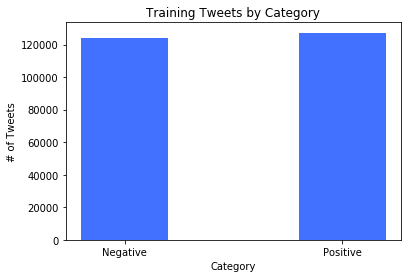

In [ ]:
#Graph Data Sets

#Graph Data to Graph number of tweets per set and category
bc_fig = plt.figure()
ax = bc_fig.add_subplot(111)

N = 2

y_train_ad = []
if trainNeg == 0:
  for i in range(0,len(y_train)):
    if y_train[i] == 0:
      trainNeg+=1
      y_train_ad.append(0)
    else:
      trainPos+=1
      y_train_ad.append(1)

s1Vals = (trainNeg,trainPos)

ind = np.arange(N)
width = 0.4

p1 = ax.bar(ind,s1Vals,width,color=(0.2588,0.4433,1.0))

ax.set_ylabel('# of Tweets')
ax.set_xlabel('Category')
ax.set_title('Training Tweets by Category')

ax.set_xticks(ind)
ax.set_xticklabels(('Negative','Positive'))

print()

In [ ]:
#Categorize labels
# 86% 83%   min df 7 batch size 32
y_train_c = to_categorical(y_train_ad)

vocab_size = x_train_v.shape[1]
batch_size = 32

#Build Model
model = keras.Sequential()
model.add(keras.layers.Dense(512, input_shape=(vocab_size,), activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(512, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(2, activation=tf.nn.softmax))

model.summary()

#Compile Model
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               7865344   
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 8,129,026
Trainable params: 8,129,026
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Categorize labels
#     min df 
#y_train_c = to_categorical(y_train_ad)

vocab_size = len(wordsList)

embed_dim = 512
lstm_out = 150
batch_size = 32

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, embed_dim,input_length=max_words))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(lstm_out,return_sequences=True)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.LSTM(int(lstm_out/2)))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 512)           3146752   
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 512)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 30, 300)           795600    
_________________________________________________________________
dropout_12 (Dropout)         (None, 30, 300)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 30, 128)           115328    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 75)                61200     
__________

In [ ]:
#Categorize labels
#81 and 80 min_df 25
#y_train_c = to_categorical(y_train_ad)

vocab_size = len(wordsList)

embed_dim = 128
lstm_out = 200
batch_size = 64

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, embed_dim,input_length=max_words))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(lstm_out,activation='relu',return_sequences=True)))
model.add(keras.layers.Dropout(0.02))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(lstm_out,activation='relu',return_sequences=True)))
model.add(keras.layers.Dropout(0.01))
model.add(keras.layers.LSTM(int(lstm_out/2),activation='relu',return_sequences=True))
model.add(keras.layers.LSTM(int(lstm_out/4)))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 128)           778112    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 400)           526400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 30, 400)           961600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 100)           200400    
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                30200     
__________

In [ ]:
#SUUUUUUUUUUUUUUUUUUUCKS


#Categorize labels
#80% and 83% min_df 20
y_train_c = to_categorical(y_train_ad)

vocab_size = len(wordsList)

embed_dim = 128
lstm_out = 200
batch_size = 64

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, embed_dim,input_length=max_words))
model.add(keras.layers.LSTM(lstm_out,activation='relu',return_sequences=True))
model.add(keras.layers.Dropout(0.015))
model.add(keras.layers.LSTM(lstm_out,activation='relu',return_sequences=True))
model.add(keras.layers.Dropout(0.005))
model.add(keras.layers.LSTM(int(lstm_out/2),activation='relu',return_sequences=True))
model.add(keras.layers.LSTM(int(lstm_out/4)))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())


In [ ]:
x_test_v = x_train_v[240000:]
y_test_c = y_train_c[240000:]
x_train_v = x_train_v[:240000]
y_train_c = y_train_c[:240000]

In [ ]:
#ONLY RUN IF LOADING WEIGHTS FROM 'model.h5' FILE

#Load Model
model.load_weights("./model.h5")
print("Successfully Loaded model from disk")

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

call_backs = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
            tf.keras.callbacks.ModelCheckpoint('./model.h5', save_best_only=True,
                            save_weights_only=False)]


#Train Model
history = model.fit(x_train_v,
                    y_train_ad,
                    batch_size=batch_size,
                    epochs=50,
                    callbacks=call_backs,
                    validation_split=0.15)

Train on 213517 samples, validate on 37680 samples
Epoch 1/50
213517/213517 [==============================] - 944s 4ms/sample - loss: 0.4629 - acc: 0.7817 - val_loss: 0.4316 - val_acc: 0.8003
Epoch 2/50
   896/213517 [..............................] - ETA: 14:14 - loss: 0.4032 - acc: 0.8170

In [ ]:
########################################
#Saves model layout to json file
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
x_test, y_test = setup(csv=1,input_file='testing.csv',zipUp=1, only_proc=1)
#x_test_v = vectorizer.transform(x_test)
#x_test_v = vectorizer.transform(x_test)
x_test_v=[]

prog = 0
emptyCount = 0
bar = progressbar.ProgressBar(maxval=len(x_test), \
    widgets=[progressbar.Percentage(), ' ', progressbar.Bar('=', '[', ']'), ' ', progressbar.SimpleProgress()])
bar.start()

for tweet in x_test:
  tempSent = []
  tweetWords = tweet.split()
  for word in tweetWords:
    if word in wordsSet:
      tempSent.append(wordsList.index(word))
  if len(tempSent) == 0:
    emptyCount += 1
 
  x_test_v.append(tempSent)
      
  prog+=1
  bar.update(prog)
bar.finish()

x_test_v = sequence.pad_sequences(x_test_v,maxlen=max_words)


y_test_ad = []

for i in range(0,len(y_test)):
  if y_test[i] == 0:
    y_test_ad.append(0)
  else:
    y_test_ad.append(1)
    
#y_test_c = to_categorical(y_test_ad)

In [ ]:
import numpy as np 
from sklearn.metrics import classification_report, roc_curve
import matplotlib.pyplot as plt
print("Downscaled values: 0-Negative 1-Positive")

#Test Model Predictions and output results
predictions = model.predict(x_test_v)

#Convert Prediction Probabilities to prediction value
predR = np.round(predictions)
predRI = predR.astype(int)

#predInd = []
#for lis in predRI:
#  predInd.append(lis.tolist().index(1))
#y_test = []
#for lis in y_test_c:
#  y_test.append(lis.tolist().index(1))


#Create and output report
report = classification_report(y_test_ad, predRI)
print(report)

#Create ROC_Curve
fpr, tpr, thresholds = roc_curve(y_test_ad,predRI,pos_label=1)

#Plot Curve
plt.plot(fpr,tpr, '-ro')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()